### Face detection with `dlib` and `mobilenet` reading with `opencv`

In [1]:
from fastai.vision import *
import cv2 as cv

In [2]:
data_path = Path("/home/ubuntu/data/")

In [282]:
video_path = data_path/"dfdc_train_part_49"

In [3]:
metadata = get_files("/home/ubuntu/data/dfdc_train_part_49/", extensions=['.json'])

In [4]:
video_files = get_files("/home/ubuntu/data/dfdc_train_part_49/", extensions=['.mp4'])

In [5]:
def read_metadata(fn):
    metadf = pd.read_json(fn).T.reset_index()
    metadf.columns = ['fname','label','split','original']
    return metadf 

In [6]:
metadf = read_metadata(metadata[0])

In [7]:
metadf.head()

,fname,label,split,original
0,dwwytkheyx.mp4,FAKE,train,nlcqykqsdp.mp4
1,bdsxxaamze.mp4,FAKE,train,xzmplldajk.mp4
2,tfceaqvefa.mp4,FAKE,train,zkksmnscsf.mp4
3,lurozpmsqd.mp4,FAKE,train,urbulrzowx.mp4
4,jvlvkijuwa.mp4,FAKE,train,wvnjcwevzo.mp4


In [8]:
metadf.groupby("label")[["fname",'original']].count()

,fname,original
label,,
FAKE,2619,2619
REAL,515,0


### video

In [42]:
def frame_img_generator(path, freq=None):
    "frame image generator for a given video file"
    vidcap = cv.VideoCapture(str(path))
    n_frames = 0
    while True:
        success = vidcap.grab()
        if not success: 
            vidcap.release()
            break   
            
        if (freq is None) or (n_frames % freq == 0):
            _, image = vidcap.retrieve()
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            yield {"frame_no":n_frames, "frame_array":image}    
            
        n_frames += 1
        
    vidcap.release()

In [43]:
%%time 
frame_gen = frame_img_generator(video_files[0])
frames = list(frame_gen); len(frames)

CPU times: user 2.72 s, sys: 44 ms, total: 2.76 s
Wall time: 711 ms


292

### audio

In [13]:
def run_command(command):
    "Run shell command as an external process, optionally write logs to logfn"
    if type(command) == str: command = shlex.split(command)
    elif type(command) == list: command = command
    else: raise AssertionError("Command should be string or list")
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout = []
    while True:
        output = process.stdout.readline()
        if output == b'' and process.poll() is not None: break
        if output: 
            _out = output.decode(); #print(_out.strip())
            stdout.append(_out)
    rc = process.poll()
    _, stderr =  process.communicate()
    err = stderr.decode(); #print(err)
    out = "".join(stdout)
    return rc

In [12]:
# %%time
# import subprocess
# from tqdm import tqdm
# for o in tqdm(video_files):
#     command = ["ffmpeg",  "-i", str(o), "-n", f"/home/ubuntu/data/dfdc_audio/{o.stem}.wav"]
#     res = run_command(command)

In [13]:
audio_files = get_files("/home/ubuntu/data/dfdc_audio/", extensions=['.wav'])

In [14]:
len(audio_files), len(video_files)

(3134, 3134)

In [15]:
fake_sample_df = metadf[metadf['label'] == "FAKE"]

In [16]:
fake_orig_audio = []

for i, (fake_fname, orig_fname) in enumerate(zip(fake_sample_df['fname'], fake_sample_df['original'])):
    try:
        fake_audio_bytes = open(f"{data_path}/dfdc_audio/{Path(fake_fname).stem}.wav", "rb").read()
        orig_audio_bytes = open(f"{data_path}/dfdc_audio/{Path(orig_fname).stem}.wav", "rb").read()
    except: continue
    if fake_audio_bytes != orig_audio_bytes: 
        fake_orig_audio.append((fake_fname, orig_fname, fake_audio_bytes, orig_audio_bytes))

In [17]:
len(fake_orig_audio)

1430

In [51]:
from IPython.display import Audio

In [54]:
Audio(filename=data_path/f'dfdc_audio/{Path(fake_orig_audio[0][0]).stem}.wav')

In [55]:
Audio(filename=data_path/f'dfdc_audio/{Path(fake_orig_audio[0][1]).stem}.wav')

## extract faces 

### `face_recognition`

- Requires high res for small face detection
- Approx 2.51*4000/3600 = 2.78 hrs for 4000 test image face detection when sample freq=10

In [115]:
import face_recognition
from tqdm import tqdm

In [114]:
def get_face_locs(frames):
    # downsample_rate = 1
    # frames = [cv.resize(frame["frame_array"],
    #                   (W//downsample_rate, H//downsample_rate))
    #                   for frame in frames]

    face_locs = face_recognition.batch_face_locations(
                frames, number_of_times_to_upsample=0, batch_size=32)
    return face_locs

Speed test

In [98]:
%%time
fname = video_files[1]
frame_gen = frame_img_generator(fname, 10)
frames = list(frame_gen)
H,W = frames[0]["frame_array"].shape[:-1]
face_locs = get_face_locs([o['frame_array'] for o in frames])

CPU times: user 5.87 s, sys: 284 ms, total: 6.15 s
Wall time: 2.49 s


Full run

In [428]:
face_recognition_res = []

for fname in tqdm(video_files[:2]):
    sample_freq = 10
    frame_gen = frame_img_generator(fname, sample_freq)
    frames = list(frame_gen)
    n_frames = len(frames)
    H,W = frames[0]["frame_array"].shape[:-1]
    face_locs = get_face_locs([o['frame_array'] for o in frames])

    res = []
    for frame_dict, locs in  zip(frames, face_locs): 
        res_dict = {}
        res_dict['frame_no'] = frame_dict['frame_no']
        res_dict['face_locs'] = locs
        res.append(res_dict)
    res = json.dumps(res)

    video_res = {"fname":fname.name, "size":(H,W),
                 "face_locs": res, "n_frames":n_frames, "sample_freq":sample_freq}
    face_recognition_res.append(video_res)

100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


In [429]:
face_recognition_faces_df = pd.DataFrame(face_recognition_res)

In [430]:
face_recognition_faces_df

,fname,size,face_locs,n_frames,sample_freq
0,yraysfvtgv.mp4,"(1280, 720)","[{""frame_no"": 0, ""face_locs"": [[278, 422, 442,...",30,10
1,jidkzoagws.mp4,"(1080, 1920)","[{""frame_no"": 0, ""face_locs"": [[185, 992, 279,...",30,10


In [446]:
# face_recognition_faces_df.to_csv(data_path/"dfdc_faces/part_49_facerec_locs.csv", index=False)

### `mobilenet-v2`

In [142]:
import tensorflow as tf

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile('./frozen_inference_graph_face.pb', 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess=tf.compat.v1.Session(graph=detection_graph, config=config)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    boxes_tensor = detection_graph.get_tensor_by_name('detection_boxes:0')    
    scores_tensor = detection_graph.get_tensor_by_name('detection_scores:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

In [300]:
def get_mobilenet_face_locs(frames):
    H,W = frames[0]["frame_array"].shape[:-1]
    downsample_rate = 2
    frames = [cv.resize(frame["frame_array"],
                      (W//downsample_rate, H//downsample_rate))
                      for frame in frames]

    (boxes, scores) = sess.run([boxes_tensor, scores_tensor],
                        feed_dict={image_tensor: frames})
    return (boxes, scores) 

Speed test

In [301]:
%%time
fname = video_files[0]
frame_gen = frame_img_generator(fname, 10)
frames = list(frame_gen)
H,W = frames[0]["frame_array"].shape[:-1]
face_locs = get_mobilenet_face_locs(frames)

boxes, scores = face_locs
boxes = (boxes*array([H,W,H,W])[None, None,...]).astype(np.int)
score_threshold = 0.7
face_locs = []
for _box, _score in zip(boxes, scores):
    face_locs.append(_box[_score > score_threshold])

CPU times: user 2.53 s, sys: 72 ms, total: 2.6 s
Wall time: 516 ms


In [435]:
mobilenet_recognition_res = []

for fname in tqdm(video_files[:2]):
    sample_freq = 10
    frame_gen = frame_img_generator(fname, sample_freq)
    frames = list(frame_gen)
    n_frames = len(frames)
    H,W = frames[0]["frame_array"].shape[:-1]
    face_locs = get_mobilenet_face_locs(frames)
    boxes, scores = face_locs
    boxes = (boxes*array([H,W,H,W])[None, None,...]).astype(np.int)
    score_threshold = 0.5
    face_locs = []
    for _box, _score in zip(boxes, scores):
        face_locs.append(_box[_score > score_threshold].tolist())

    res = []
    for frame_dict, locs in  zip(frames, face_locs): 
        res_dict = {}
        res_dict['frame_no'] = frame_dict['frame_no']
        res_dict['face_locs'] = locs
        res.append(res_dict)
    res = json.dumps(res)

    video_res = {"fname":fname.name, "size":(H,W), 
                 "face_locs": res, "n_frames":n_frames, "sample_freq":sample_freq}
    mobilenet_recognition_res.append(video_res)

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


In [436]:
mobilenet_faces_df = pd.DataFrame(mobilenet_recognition_res)

In [438]:
mobilenet_faces_df

,fname,size,face_locs,n_frames,sample_freq
0,yraysfvtgv.mp4,"(1280, 720)","[{""frame_no"": 0, ""face_locs"": [[289, 282, 468,...",30,10
1,jidkzoagws.mp4,"(1080, 1920)","[{""frame_no"": 0, ""face_locs"": [[156, 911, 288,...",30,10


In [439]:
# mobilenet_faces_df.to_csv(data_path/"dfdc_faces/part_49_mobilenet_locs.csv", index=False)

### Visualize

In [453]:
face_recognition_faces_df = pd.read_csv(data_path/"dfdc_faces/part_49_facerec_locs.csv")
mobilenet_faces_df = pd.read_csv(data_path/"dfdc_faces/part_49_mobilenet_locs.csv")

In [498]:
face_recognition_faces_df

,fname,size,face_locs,n_frames,sample_freq
0,yraysfvtgv.mp4,"(1280, 720)","[{""frame_no"": 0, ""face_locs"": [[278, 422, 442,...",30,10
1,jidkzoagws.mp4,"(1080, 1920)","[{""frame_no"": 0, ""face_locs"": [[185, 992, 279,...",30,10
2,uowiocuqqt.mp4,"(1080, 1920)","[{""frame_no"": 0, ""face_locs"": [[268, 1019, 432...",30,10
3,sigtxuuutc.mp4,"(1080, 1920)","[{""frame_no"": 0, ""face_locs"": [[119, 1052, 283...",30,10
4,uzawooqxrq.mp4,"(1080, 1920)","[{""frame_no"": 0, ""face_locs"": [[145, 959, 282,...",30,10
...,...,...,...,...,...
3129,njcaovbtyh.mp4,"(1080, 1920)","[{""frame_no"": 0, ""face_locs"": [[159, 1042, 296...",30,10
3130,tbdgixstek.mp4,"(1080, 1920)","[{""frame_no"": 0, ""face_locs"": [[218, 1068, 382...",30,10
3131,jwbkfbbcrr.mp4,"(1080, 1920)","[{""frame_no"": 0, ""face_locs"": [[202, 720, 366,...",30,10
3132,xfmbwdszed.mp4,"(1080, 1920)","[{""frame_no"": 0, ""face_locs"": [[157, 1088, 393...",30,10


In [499]:
mobilenet_iter = mobilenet_faces_df.iterrows()
facerec_iter = face_recognition_faces_df.iterrows()

In [523]:
_,mobilenet_row = next(mobilenet_iter)
_,facerec_row = next(facerec_iter)

In [524]:
assert mobilenet_row['fname'] == facerec_row['fname']
fname = facerec_row['fname']
mobilenet_face_locs = json.loads(mobilenet_row["face_locs"])
facerec_face_locs = json.loads(facerec_row["face_locs"])

In [525]:
frame_gen = frame_img_generator(video_path/fname, 10)
frames = list(frame_gen)

In [526]:
metadf[metadf.fname == fname]

,fname,label,split,original
1270,ueuewllftq.mp4,FAKE,train,qdantvtdji.mp4


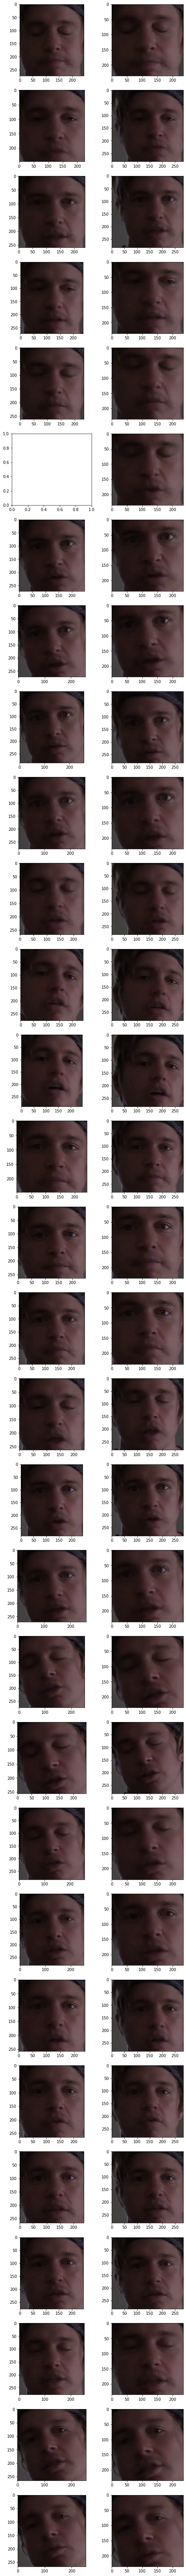

In [527]:
axes = subplots(len(frames), 2)
for ax, mobilenet_locs, facerec_locs, frame in zip(axes, 
                                                 mobilenet_face_locs, 
                                                 facerec_face_locs,
                                                 frames): 
    try:
        ymin, xmin, ymax, xmax = mobilenet_locs['face_locs'][0]
        ax[0].imshow(frame['frame_array'][ymin:ymax,xmin:xmax])
    except: pass
        
    try:
        top, right, bottom, left = facerec_locs['face_locs'][0]
        ax[1].imshow(frame['frame_array'][top:bottom,left:right])
    except: pass